In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

### Calculation and plotting of monthly climatology of Soil Moisture

Import the Soil Moisture data. This is model calculated CPC soil moisture data from NOAA.


In [2]:
sw = xr.open_dataset("/scratch/dklein3/soilw.mon.mean.v2.nc")
sw

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 884)
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2021-08-01
Data variables:
    soilw    (time, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.0
    title:          CPC Soil Moisture
    institution:    NOAA/ESRL PSD
    dataset_title:  CPC Soil Moisture
    history:        Wed Oct 18 15:13:37 2017: ncks -d time,,-2 soilw.mon.mean...
    NCO:            4.6.9
    References:     https://www.psl.noaa.gov/data/gridded/data.cpcsoil.html

Calculating the monthly climatology

In [3]:
sw_monthly_means = sw.groupby('time.month').mean(dim='time')
sw_monthly_means

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, month: 12)
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    soilw    (month, lat, lon) float32 nan nan nan nan ... 8.143 8.15 8.148

Adjusting the month coordinates from numbers to months

In [7]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
sw_monthly_means = sw_monthly_means.assign_coords({"month": ("month",months)})
sw_monthly_means

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, month: 12)
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * month    (month) <U3 'Jan' 'Feb' 'Mar' 'Apr' ... 'Sep' 'Oct' 'Nov' 'Dec'
Data variables:
    soilw    (month, lat, lon) float32 nan nan nan nan ... 8.143 8.15 8.148

Making the plots

Text(0.5, 0.98, 'CPC Soil Moisture from NOAA')

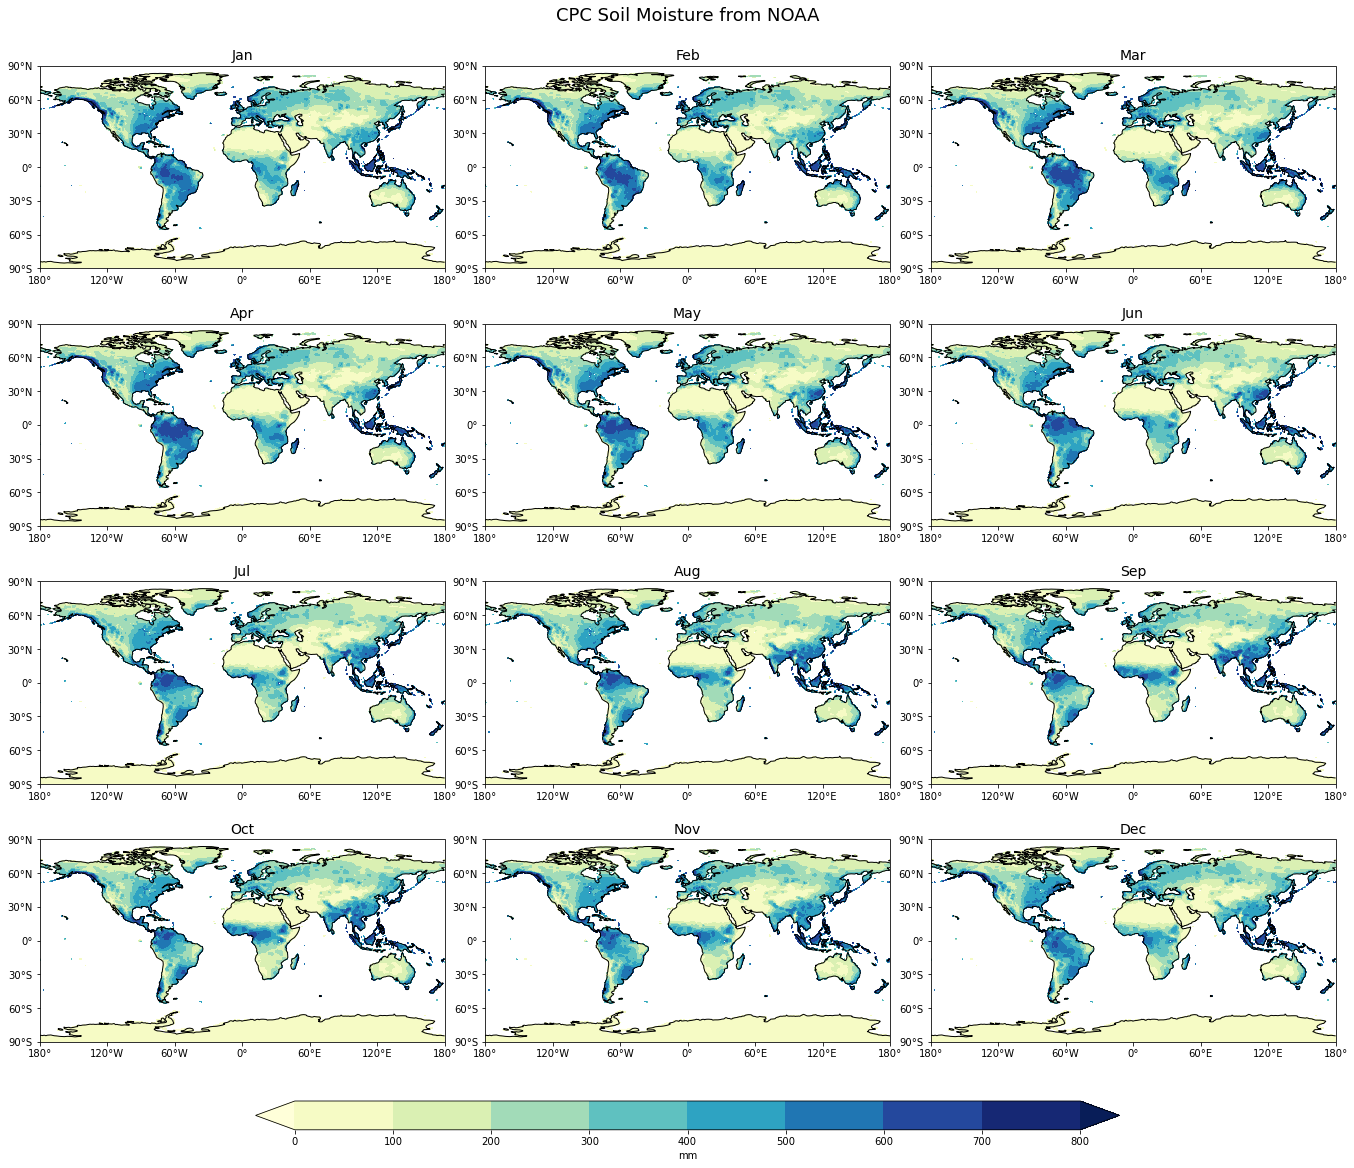

In [20]:
# Define the color levels for the plots
clevs=np.arange(0,900,100)
# Define the figure and each axis for 4 rows and 3 columns
fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,20))

# axs is a 2 dimensional array of `GeoAxes`.  
# Flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the months and plot
for i,mon in enumerate(sw_monthly_means['month']):

        # Select the month
        data=sw_monthly_means['soilw'].sel(month=mon)

        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=sw_monthly_means['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,sw_monthly_means['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='YlGnBu',extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the month
        axs[i].set_title(mon.values,fontsize=14)

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.95, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.1)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='mm')

# Add a big title at the top
plt.suptitle('CPC Soil Moisture from NOAA', fontsize=18)